# Walkthrough 5: Experimentation and batch jobs 
This notebook runs on Oqtant hardware and uses **4 jobs** 

## Introduction ##

Multiple jobs are needed to either average results or to scan control parameters to map out dependencies and trends.  In this walkthrough, we will explore ways of submitting and managing lists of *QuantumMatter* objects.  


This, along with all our example notebooks are publicly available for download from our [GitLab repository.](https://gitlab.com/infleqtion/albert/oqtant-documentation/-/tree/main/oqtant_documentation/docs/examples?ref_type=heads)

### Imports and user authentication ###

In [ ]:
import matplotlib.pyplot as plt
from oqtant.schemas.quantum_matter import QuantumMatterFactory

qmf = QuantumMatterFactory()
qmf.get_login()

In [ ]:
qmf.get_client()

## Submit a list of QuantumMatter objects to generate many independent jobs

### Create a list of QuantumMatter objects ###

Make a list of *QuantumMatter* objects that each have a different target temperature:

In [3]:
N = 2
matters = [
    qmf.create_quantum_matter(
        temperature=50 * (n + 1), name="quantum matter run " + str(n + 1) + "/" + str(N)
    )
    for n in range(N)
]

list(map(type, matters))

[oqtant.schemas.quantum_matter.QuantumMatter,
 oqtant.schemas.quantum_matter.QuantumMatter]

### Submit the list to Oqtant QMS ###

Submit many independent jobs to be run on the hardware. Each of these jobs enters Oqtant's queueing system at nearly the same time, so they will *likely* be executed near each other in time, depending on current queue usage.

In [4]:
[matter.submit(track=True) for matter in matters]

Submitting 1 job(s):

- Job: quantum matter run 1/2
  Job ID: e7348377-aa27-4e5a-b9a4-d781bd807eb6

Tracking 1 job(s):

- Job: quantum matter run 1/2
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: quantum matter run 2/2
  Job ID: ffae5850-541a-4835-ae12-ed555246a20a

Tracking 1 job(s):

- Job: quantum matter run 2/2
  - RUNNING
  - COMPLETE

All job(s) complete


[None, None]

### Access job results ###

Once all our submitted jobs are complete, we access the results in the same way as if we had submitted the programs individually:

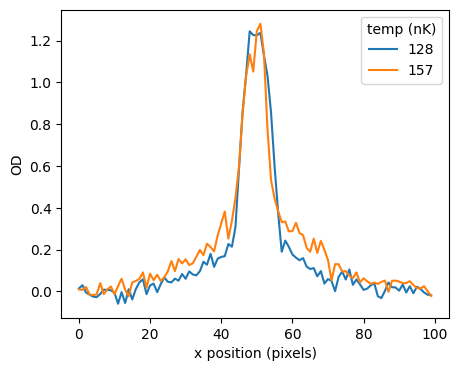

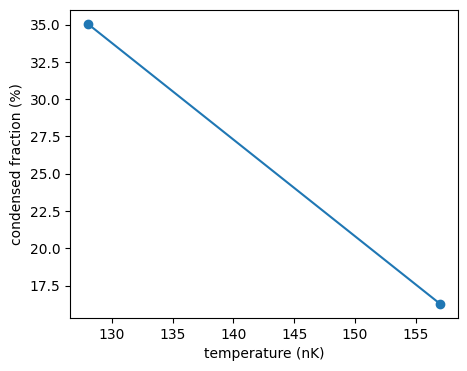

In [5]:
# retrieve jobs from server one at a time, creating corresponding local job objects
[matter.get_result() for matter in matters]

# access the results individually and plot them together
lns = []
lbls = []
plt.figure(figsize=(5, 4))
for matter in matters:
    (ln,) = plt.plot(matter.output.get_slice(axis="x"))
    plt.xlabel("x position (pixels)")
    plt.ylabel("OD")
    lns.append(ln)
    lbls.append(str(matter.output.temperature_nk))
plt.legend(lns, lbls, loc="upper right", title="temp (nK)")
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(
    [matter.output.temperature_nk for matter in matters],
    [
        (
            100 * matter.output.condensed_atom_number / matter.output.tof_atom_number
            if matter.output.tof_atom_number > 0
            else 0
        )
        for matter in matters
    ],
    "-o",
)
plt.xlabel("temperature (nK)")
plt.ylabel("condensed fraction (%)")
plt.show()

## Generate and submit a "batch" job ##

There is also the option to submit a list of *matter* objects as a single *batch* job, which guarantees that the sequence executes sequentially on the hardware.  This feature is useful for detailed experimentation or investigation, where subsequent shots need to be compared to each other in detail.  Using sequential hardware shots reduces system drift or inconsistency.  

In the case of bundling into a single batch job, only one job id will be generated.  Programmatically, the batch job will be composed of multiple *run*s on Oqtant hardware, and retrieving job results will require specifying the run number $1 \ldots N$ when fetching the job results, where there were $N$ runs in the job.    

*NOTE: The resulting name of a batch job will default to the name given to the first QuantumMatter object in the provided list.  Alternatively, a global name can be provided at the point of submission to the client.*  

*NOTE: Each individual *run* is charged against your job quota.  A single batch job will naturally contain multiple runs.*

### Create a list of QuantumMatter objects to submit as a batch ###

In [7]:
# create a list of QuantumMatter objects
N = 2
matters = [
    qmf.create_quantum_matter(
        temperature=50 * (n + 1),
        lifetime=20 + (n * 2),
        time_of_flight=3 + (n * 2),
        note=f"{n + 1}/{N}",  # notes persist in batches and will remain tied to each matter object
    )
    for n in range(N)
]

### Submit the list as a batch job ###

Submit our list of *matter* objects to generate a batch job using the `QuantumMatterFactory.submit_list_as_batch()` method:

In [8]:
# submit the list as a batch that will run sequentially on the hardware
# returns only a single job id, e.g., "1cdb4ff7-c5ed-46d3-a667-8b12f0cd1349"
matter_batch = qmf.submit_list_as_batch(
    matter_list=matters, name="a batch!", track=True  # global batch name
)

Submitting 1 job(s):

- Job: a batch!
  Job ID: 94397237-87b8-4d32-9902-df195383ca61

Tracking 1 job(s):

- Job: a batch!
  - RUNNING
  - COMPLETE

All job(s) complete


### Access batch job results ###

Retrieve batch job run results for each run by specifying the desired run number using the `QuantumMatter.get_result()` method.  If omitted (as for non-batch jobs with just a single run), the data for the first run will be fetched.  

*NOTE: The added complication of managing multiple runs within a single job is is an unavoidable consequence of ensuring that the runs execute sequentially on the hardware.*

In [9]:
matter_batch.get_result()  # by default this matter object will be set to the first run (input/output values)
print(f"Run: {matter_batch.run} of {len(matters)}")
print(f"Job Name: {matter_batch.name}")
print(f"Job Note: {matter_batch.note}")
print(f"Input Values: {matter_batch.input}")
print(f"Temperature: {matter_batch.output.temperature_nk}")

print("\n")

matter_batch.get_result(
    run=2
)  # the matter object will now be set to the second run (input/output values)
print(f"Run: {matter_batch.run} of {len(matters)}")
print(f"Job Name: {matter_batch.name}")
print(f"Job Note: {matter_batch.note}")
print(f"Input Values: {matter_batch.input}")
print(f"Temperature: {matter_batch.output.temperature_nk}")

print("\n")

# the matter object is now set for the second run, subsequent calls to get_result will continue to use data
# for the second run until given a different run value
matter_batch.get_result()
print(f"Run: {matter_batch.run} of {len(matters)}")
matter_batch.get_result(run=1)
print(f"Run: {matter_batch.run} of {len(matters)}")

# to determine what run a particular matter is using at anytime you can
# print(matter_batch.run)

Run: 1 of 2
Job Name: a batch!
Job Note: 1/2
Input Values: end_time_ms=20 image_type=<ImageType.TIME_OF_FLIGHT: 'TIME_OF_FLIGHT'> time_of_flight_ms=3 rf_evaporation=RfEvaporation(times_ms=[-1100, -1050, -800, -300, 0], frequencies_mhz=[21.12, 12.12, 5.12, 0.62, 0.01675], powers_mw=[600.0, 800.0, 600.0, 400.0, 400.0], interpolation=<RfInterpolationType.LINEAR: 'LINEAR'>) optical_barriers=None optical_landscape=None lasers=None
Temperature: 5444


Run: 2 of 2
Job Name: a batch!
Job Note: 2/2
Input Values: end_time_ms=22 image_type=<ImageType.TIME_OF_FLIGHT: 'TIME_OF_FLIGHT'> time_of_flight_ms=5 rf_evaporation=RfEvaporation(times_ms=[-1100, -1050, -800, -300, 0], frequencies_mhz=[21.12, 12.12, 5.12, 0.62, 0.01675], powers_mw=[600.0, 800.0, 600.0, 400.0, 400.0], interpolation=<RfInterpolationType.LINEAR: 'LINEAR'>) optical_barriers=None optical_landscape=None lasers=None
Temperature: 242


Run: 2 of 2
Run: 1 of 2


Plot the results together as above, but augment our approach at extracting the data:

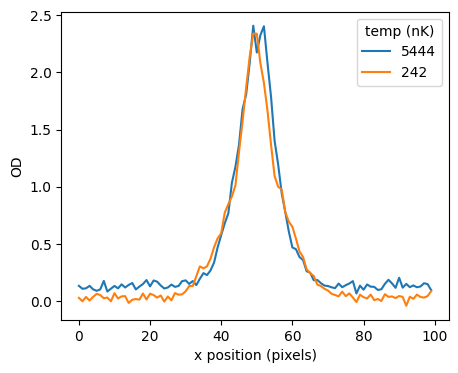

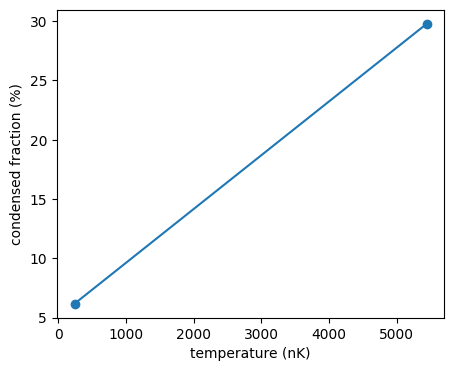

In [10]:
lns = []
lbls = []
plt.figure(figsize=(5, 4))
for run in range(len(matters)):
    matter_batch.get_result(run=run + 1)
    (ln,) = plt.plot(matter_batch.output.get_slice(axis="x"))
    plt.xlabel("x position (pixels)")
    plt.ylabel("OD")
    lns.append(ln)
    lbls.append(str(matter_batch.output.temperature_nk))
plt.legend(lns, lbls, loc="upper right", title="temp (nK)")
plt.show()

temps = []
atoms = []
plt.figure(figsize=(5, 4))
for run in range(len(matters)):
    matter_batch.get_result(run=run + 1)
    temps.append(matter_batch.output.temperature_nk)
    atoms.append(
        (
            100
            * matter_batch.output.condensed_atom_number
            / matter_batch.output.tof_atom_number
            if matter_batch.output.tof_atom_number > 0
            else 0
        )
    )
plt.plot(temps, atoms, "-o")
plt.xlabel("temperature (nK)")
plt.ylabel("condensed fraction (%)")
plt.show()

### Saving and loading batch job results ###

When working with jobs that have multiple runs it is important to differenciate between then while saving their data since they share the same job id. By using `QuantumMatter.get_result` we are able to swap the input and output data of a job while persisting it's id.

To address this issue the `QuantumMatter.write_job_to_file` method will automatically detect when a job has more than one run and append the appropriate indictor to the end of the file name: _id_run_n_of_N.txt_

In [11]:
matter_batch.get_result(run=1)
matter_batch.write_to_file()
matter_batch.get_result(run=2)
matter_batch.write_to_file()

Wrote file: "94397237-87b8-4d32-9902-df195383ca61_run_1_of_2.txt"
Wrote file: "94397237-87b8-4d32-9902-df195383ca61_run_2_of_2.txt"
